In [1]:
from snow import SnowModel
from seb import SebModel
from soil import SoilModel
from thermal import Thermal
from swrad import SWrad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
#fforc = r'/Users/jpnousu/Documents/Forc_test/FORCING_LOMPOLO.nc'
#forc = xr.open_dataset(fforc).sel(time=slice('2020-10-01', '2021-07-01'))
#forc = forc.to_dataframe()

In [3]:
fforc = r'/Users/jpnousu/FSM2/met_Sod_1314.txt'
fout = r'/Users/jpnousu/FSM2/Sod_1314_stat.txt'
foutf = r'/Users/jpnousu/FSM2/Sod_1314_flux.txt'
forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'))
out = pd.read_csv(fout, header=None, delimiter=r"\s+")
outf = pd.read_csv(foutf, header=None, delimiter=r"\s+")
col_names = ['DIR_SWdown', 'LWdown', 'Snowf', 'Rainf', 'Tair', 'HUMREL', 'Wind', 'PSurf']
forc.columns = col_names

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_42036/1337717768.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'))


In [4]:
seb = SebModel()
snow = SnowModel()
soil = SoilModel()
thermal = Thermal()
swrad = SWrad()

In [5]:
dt = 3600
Ncnpy = 0
cveg = np.zeros(Ncnpy) 
Ds1 = np.array(5)
fcans = np.zeros(Ncnpy)
lveg = np.zeros(Ncnpy)
fsnow = np.zeros(1)
gs1 = np.zeros(1)
ks1 = np.zeros(1)
Sveg = np.zeros(1)
SWveg = np.zeros(1)
tdif = np.zeros(1)
Ts1 = np.zeros(1)
Tveg0 = np.zeros(1)
Ua = np.zeros(1)+0.1
VAI = np.zeros(1)
vegh = np.zeros(1)
zT = np.zeros(1)
zU = np.zeros(1)
Sice = np.ones(shape=3)
Sliq = np.ones(shape=3)
Tsoil = np.ones(3)+273.15
Tsnow = np.ones(3)+273.15
Tsrf = np.ones(1)+273.15
ksoil = np.ones(3)*0.24
Nsnow = np.zeros(1)
Rgrn = np.zeros(3)
Dsnw = np.zeros(3)
Vsmc = np.zeros(3)+0.3
alb0 = np.zeros(1)+0.2
albs = 0.9
elev = np.zeros(1)+100

# outputs
Tsoillist = []
swelist = []
hslist = []
Meltlist = []
Gsrflist = []
Esrflist = []
Hlist = []
LElist = []
subllist = []
Tsrflist = []
LWoutlist = []

for i in range(len(forc)):
#for i in range(len(forc['time'])):
    
    d_forc = forc.iloc[i]
    #d_forc = forc.isel(time=i)

    print('step', i)

    LW = np.array(d_forc['LWdown'].data)
    Ps = np.array(d_forc['PSurf'].data)
    SWsrf = np.array(d_forc['DIR_SWdown'].data)
    Ta = np.array(d_forc['Tair'].data)
    Rf = np.array(d_forc['Rainf'].data)
    Sf = np.array(d_forc['Snowf'].data)
    Ua = np.array(d_forc['Wind'].data)
    RH = np.array(d_forc['HUMREL'].data)

    albs, fsnow, SWout, SWsrf, SWsub, SWveg, tdif = swrad.run_timestep(albs=albs, alb0=alb0, 
                                                                       dt=dt, elev=elev, Sdif=SWsrf*0.3, 
                                                                       Sdir=SWsrf*0.7, Sf=Sf, Tsrf=Tsrf, 
                                                                       Dsnw=Dsnw, fcans=fcans, lveg=lveg)

    Ds1, gs1, ks1, Ts1, csoil, ksnow, ksoil = thermal.run_timestep(Nsnow=Nsnow, Dsnw=Dsnw,
                                                                   Sice=Sice, Sliq=Sliq,
                                                                   Tsnow=Tsnow, Tsoil=Tsoil,
                                                                   Vsmc=Vsmc)

    Esrf, Gsrf, H, LE, LWout, LWsub, Melt, subl, Usub, Eveg, Tsrf = seb.run_timestep(cveg=cveg, Ds1=Ds1, 
                                                                                      dt=dt, fcans=fcans, 
                                                                                      fsnow=fsnow, gs1=gs1, 
                                                                                      ks1=ks1, lveg=lveg, LW=LW, 
                                                                                      Ps=Ps, RH=RH, SWsrf=SWsrf, 
                                                                                      Sveg=Sveg, SWveg=SWveg, 
                                                                                      Ta=Ta, tdif=tdif, Ts1=Ts1, 
                                                                                      Tveg0=Tveg0, Ua=Ua, VAI=VAI, 
                                                                                      vegh=vegh, zT=zT, zU=zU, Sice=Sice)
    
    Gsoil, Roff, hs, swe, Wflx, Sice, Sliq, Dsnw, Rgrn, Tsnow, Tsoil, Nsnow = snow.run_timestep(dt=dt, 
                                                                                                drip=0, 
                                                                                                Esrf=Esrf, 
                                                                                                Gsrf=Gsrf,
                                                                                                ksoil=ksoil, 
                                                                                                Melt=Melt, 
                                                                                                Rf=Rf, 
                                                                                                Sf=Sf, 
                                                                                                Ta=Ta, 
                                                                                                trans=0, 
                                                                                                Tsrf=Tsrf,
                                                                                                unload=0, 
                                                                                                Tsoil=Tsoil,
                                                                                                ksnow=ksnow)

    Tsoil = soil.run_timestep(dt, Gsoil, csoil, ksoil, Tsoil)
    
    swelist.append(swe)
    hslist.append(hs)
    Meltlist.append(Melt)
    Gsrflist.append(Gsrf)
    Tsoillist.append(Tsoil[0])
    Esrflist.append(Esrf)
    Hlist.append(H)
    LElist.append(LE)
    subllist.append(subl)
    Tsrflist.append(Tsrf)
    LWoutlist.append(LWout)

step 0
ksnow [0.24 0.24 0.24]
step 1
ksnow [0.24 0.24 0.24]
step 2
ksnow [0.24 0.24 0.24]
step 3
ksnow [0.24 0.24 0.24]
step 4
ksnow [0.24 0.24 0.24]
step 5
ksnow [0.22988379 0.24       0.24      ]
initial ksnow [0.22988379 0.24       0.24      ]
initial ksoil [0.80404654 0.80404654 0.80404654]
step 6
ksnow [0.24 0.24 0.24]
step 7
ksnow [0.24 0.24 0.24]
step 8
ksnow [0.24 0.24 0.24]
step 9
ksnow [0.24 0.24 0.24]
step 10
ksnow [0.24 0.24 0.24]
step 11
ksnow [0.24 0.24 0.24]
step 12
ksnow [0.24 0.24 0.24]
step 13
ksnow [0.24 0.24 0.24]
step 14
ksnow [0.24 0.24 0.24]
step 15
ksnow [0.24 0.24 0.24]
step 16
ksnow [0.24 0.24 0.24]
step 17
ksnow [0.24 0.24 0.24]
step 18
ksnow [0.22988379 0.24       0.24      ]
initial ksnow [0.22988379 0.24       0.24      ]
initial ksoil [0.80404654 0.80404654 0.80404654]
step 19
ksnow [0.25990619 0.24       0.24      ]
initial ksnow [0.25990619 0.24       0.24      ]
initial ksoil [0.80404654 0.80404654 0.80404654]
step 20
ksnow [1.46837528 0.24       0.24 

/Users/jpnousu/pyFSM2/src/seb.py:514: RuntimeWarning: invalid value encountered in power
  2 * np.log((1 + (1 - 16 * zeta) ** 0.25) / 2) +
/Users/jpnousu/pyFSM2/src/seb.py:515: RuntimeWarning: invalid value encountered in sqrt
  np.log((1 + (1 - 16 * zeta) ** 0.5) / 2) -
/Users/jpnousu/pyFSM2/src/seb.py:516: RuntimeWarning: invalid value encountered in power
  2 * np.arctan((1 - 16 * zeta) ** 0.25) +
/Users/jpnousu/pyFSM2/src/seb.py:528: RuntimeWarning: invalid value encountered in sqrt
  2 * np.log((1 + (1 - 16 * zeta) ** 0.5) / 2))


step 433
ksnow [0.24 0.24 0.24]
step 434
ksnow [0.24 0.24 0.24]
step 435
ksnow [0.24 0.24 0.24]
step 436
ksnow [0.24 0.24 0.24]
step 437
ksnow [0.24 0.24 0.24]
step 438
ksnow [0.24 0.24 0.24]
step 439
ksnow [0.24 0.24 0.24]
step 440
ksnow [0.24 0.24 0.24]
step 441
ksnow [0.24 0.24 0.24]
step 442
ksnow [0.24 0.24 0.24]
step 443
ksnow [0.24 0.24 0.24]
step 444
ksnow [0.24 0.24 0.24]
step 445
ksnow [0.22988379 0.24       0.24      ]
initial ksnow [0.22988379 0.24       0.24      ]
initial ksoil [1.07589368 1.06954462 0.86024923]
step 446
ksnow [0.22988379 0.24       0.24      ]
initial ksnow [0.22988379 0.24       0.24      ]
initial ksoil [1.0751238  1.07019592 0.86189359]
step 447
ksnow [0.22988379 0.24       0.24      ]
initial ksnow [0.22988379 0.24       0.24      ]
initial ksoil [1.07450486 1.07069312 0.86356376]
step 448
ksnow [0.22988379 0.24       0.24      ]
initial ksnow [0.22988379 0.24       0.24      ]
initial ksoil [1.07402051 1.07107328 0.86525449]
step 449
ksnow [0.229883

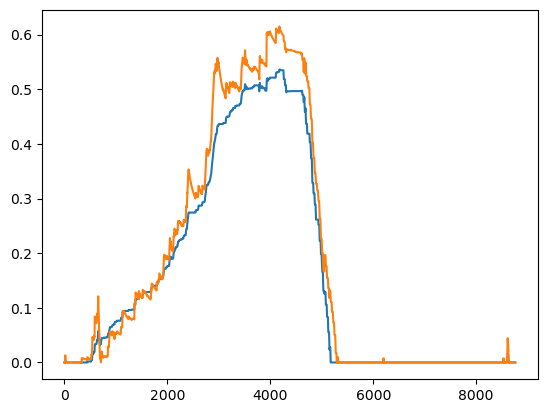

In [6]:
plt.plot(hslist)
plt.plot(out.iloc[:,4])

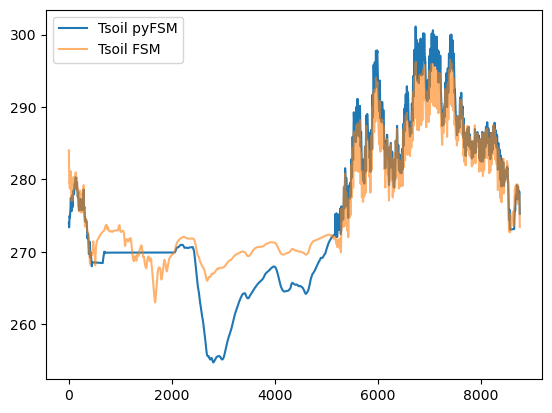

In [7]:
plt.plot(Tsoillist, label='Tsoil pyFSM')
#plt.plot(out.iloc[:,10], label='Tsoil FSM2')
plt.plot(out.iloc[:,7], label='Tsoil FSM', alpha=0.6)
plt.legend()

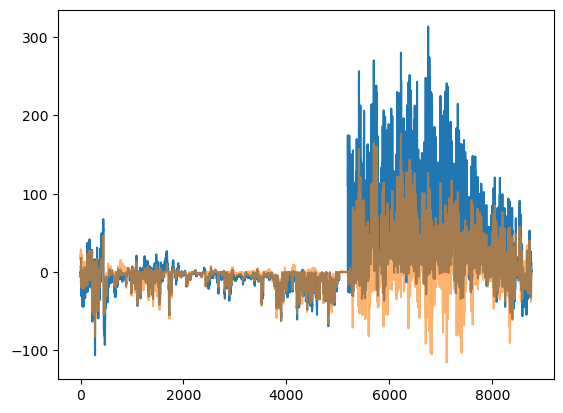

In [8]:
plt.plot(Hlist)
plt.plot(outf.iloc[:,4], alpha=0.6)


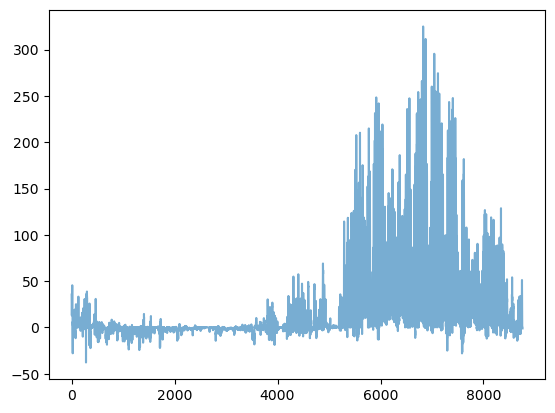

In [9]:
#plt.plot(LElist)
plt.plot(outf.iloc[:,5], alpha=0.6)


ValueError: Input could not be cast to an at-least-1D NumPy array

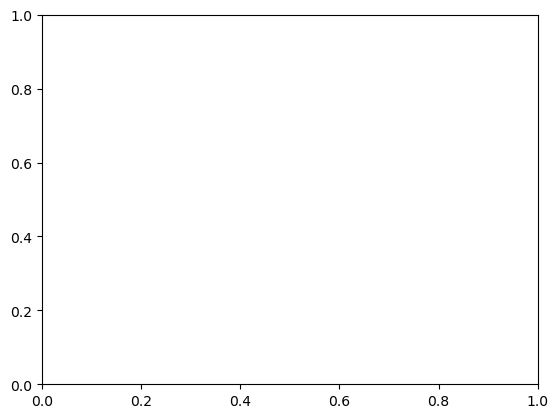

In [10]:
plt.plot(LWoutlist)
plt.plot(outf.iloc[:,6], alpha=0.6)

ValueError: Input could not be cast to an at-least-1D NumPy array

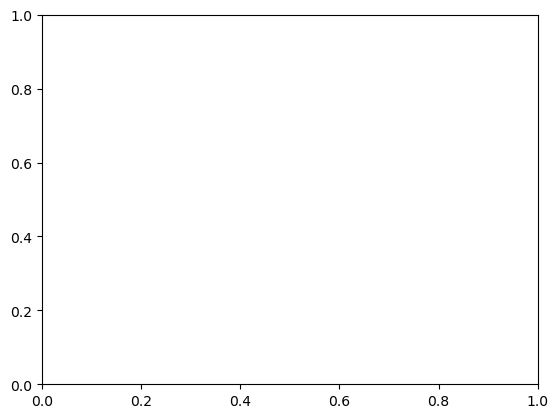

In [10]:
plt.plot(Meltlist)
plt.plot(outf.iloc[:,7], alpha=0.6)

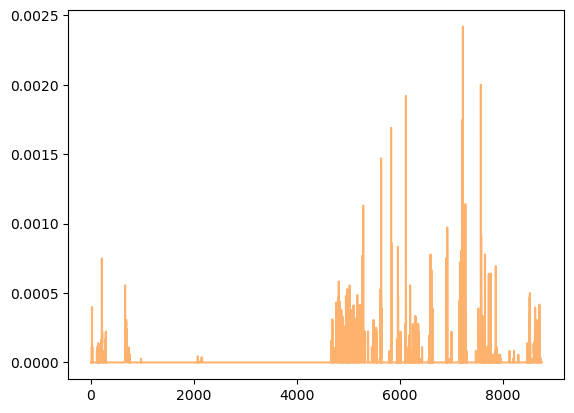

In [11]:
plt.plot(Roff)
plt.plot(outf.iloc[:,8], alpha=0.6)

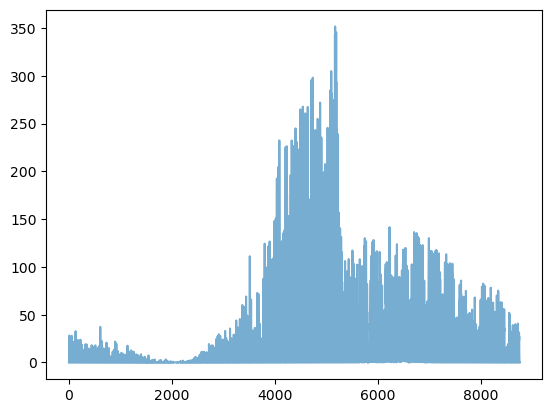

In [13]:
#plt.plot(SWout)
plt.plot(outf.iloc[:,10], alpha=0.6)